# Imports

In [1]:
import acquire
import prepare
import encode
import evaluate_models

import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Acquire

In [2]:
telco = acquire.get_telco_data()

# Prepare

In [3]:
train, test, validate = prepare.prep_telco(telco, train_size=.8, seed=123)

## Encode

In [4]:
train, test, validate = encode.encoded_df(train, test, validate)

# Feature Engineering

In [5]:
# Combine online_features (online security, device protection, tech support)

In [46]:
train['online_features']    = train.online_security_encoded + train.device_protection_encoded + train.tech_support_encoded
validate['online_features'] = validate.online_security_encoded + validate.device_protection_encoded + validate.tech_support_encoded
test['online_features']     = test.online_security_encoded + test.device_protection_encoded + test.tech_support_encoded

# Modeling

In [7]:
X_train = train[['tenure', 'contract_type_encoded', 'monthly_charges', 'payment_type_encoded']]
y_train = train.churn_encoded

X_validate = validate[['tenure', 'contract_type_encoded', 'monthly_charges', 'payment_type_encoded']]
y_validate = validate.churn_encoded            

In [8]:
predictions = pd.DataFrame({'actual' : y_validate})

## Logistic Regregression

In [9]:
log_reg_model = LogisticRegression(random_state=123).fit(X_train, y_train)

In [10]:
predictions['logistic Regression: churn ~ tenure, contract type, monthly charges'] = log_reg_model.predict(X_validate)

In [11]:
predictions.actual.value_counts()

0    845
1    282
Name: actual, dtype: int64

In [12]:
log_reg_accuracy = log_reg_model.score(X_validate, y_validate)

## Identify/Plot Thresholds

In [13]:
thresholds = evaluate_models.evaluate_thresholds(predictions.actual, log_reg_model.predict(X_validate))

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
thresholds.head()

,threshold,precision,recall,accuracy
0,0.00,0.635514,0.48227,0.801242
1,0.01,0.635514,0.48227,0.801242
2,0.02,0.635514,0.48227,0.801242
3,0.03,0.635514,0.48227,0.801242
4,0.04,0.635514,0.48227,0.801242


In [15]:
thresholds.recall.sort_values(ascending=False)

50     0.48227
36     0.48227
26     0.48227
27     0.48227
28     0.48227
        ...   
69     0.48227
70     0.48227
71     0.48227
72     0.48227
100    0.00000
Name: recall, Length: 101, dtype: float64

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


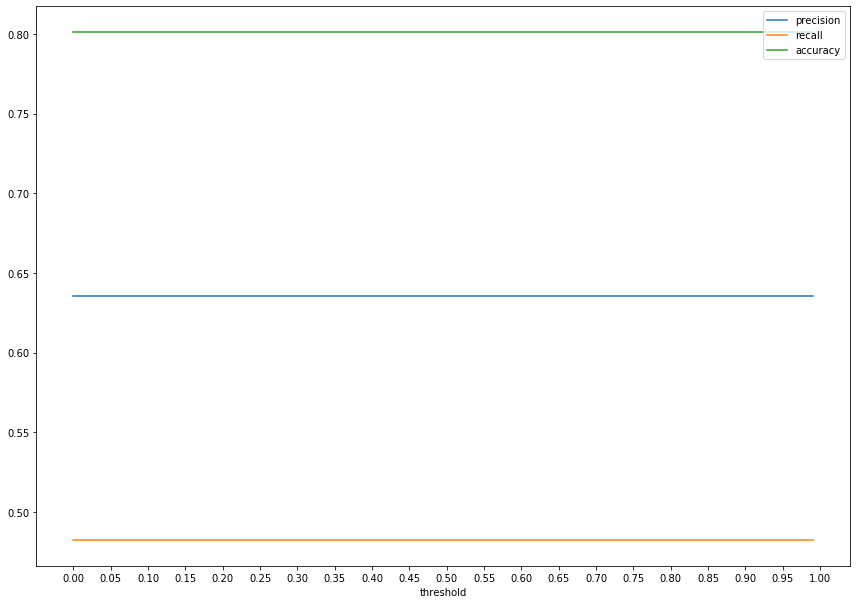

In [16]:
evaluate_models.plot_metrics_by_thresholds(predictions.actual, log_reg_model.predict(X_validate))

### Generate ROC Test

In [17]:
predictions.head()

,actual,"logistic Regression: churn ~ tenure, contract type, monthly charges"
5854,0,0
797,0,0
3188,0,0
2254,0,0
5732,0,0


In [18]:
roc_auc_score = roc_auc_score(predictions.actual, log_reg_model.predict(X_validate))

In [19]:
print('Accuracy: {: .2f}, ROC Score: {: .2f}'.format(log_reg_accuracy, roc_auc_score))

Accuracy:  0.80, ROC Score:  0.69


## Decision Tree 

In [20]:
tree_model = DecisionTreeClassifier(max_depth=3, random_state=123).fit(X_train, y_train)

In [21]:
predictions['Decision Tree: churn ~ tenure, contract type, monthly charges'] = tree_model.predict(X_validate)

In [22]:
predictions.head()

,actual,"logistic Regression: churn ~ tenure, contract type, monthly charges","Decision Tree: churn ~ tenure, contract type, monthly charges"
5854,0,0,0
797,0,0,0
3188,0,0,0
2254,0,0,0
5732,0,0,0


In [23]:
tree_accuracy = tree_model.score(X_validate, y_validate)

## Random Forest

In [24]:
forest_model = RandomForestClassifier(n_estimators=10, random_state=123).fit(X_train, y_train)

In [25]:
predictions['Random Forest: churn ~ tenure, contract type, monthly charges'] = forest_model.predict(X_validate)

In [26]:
forest_accuracy = forest_model.score(X_validate, y_validate)

## K Nearest Neighbors 

In [27]:
knn = KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train)

In [28]:
predictions['KNN: churn ~ tenure, contract type, monthly charges'] = knn.predict(X_validate)

In [29]:
knn_accuracy = knn.score(X_train, y_train)

In [30]:
predictions.head()

,actual,"logistic Regression: churn ~ tenure, contract type, monthly charges","Decision Tree: churn ~ tenure, contract type, monthly charges","Random Forest: churn ~ tenure, contract type, monthly charges","KNN: churn ~ tenure, contract type, monthly charges"
5854,0,0,0,0,0
797,0,0,0,0,0
3188,0,0,0,0,0
2254,0,0,0,0,0
5732,0,0,0,0,0


In [31]:
predictions[['actual', 'KNN: churn ~ tenure, contract type, monthly charges']]

,actual,"KNN: churn ~ tenure, contract type, monthly charges"
5854,0,0
797,0,0
3188,0,0
2254,0,0
5732,0,0
...,...,...
4811,0,0
6879,0,0
5366,1,0
1301,0,0


In [32]:
predictions.to_csv('model_output.csv')

# Evaluate

## Accuracy

In [33]:
print('''
Model Accuracy Rates - 
    Logistic Regression: {: .2f} 
    Decision Tree:       {: .2f}
    Random Forest:       {: .2f}
    K Nearest Neighbor   {: .2f}
'''.format(log_reg_accuracy, tree_accuracy, forest_accuracy, knn_accuracy))


Model Accuracy Rates - 
    Logistic Regression:  0.80 
    Decision Tree:        0.80
    Random Forest:        0.79
    K Nearest Neighbor    0.83



## Confusion Matrix

In [34]:
# Logistic Regression
print(confusion_matrix(predictions.actual, log_reg_model.predict(X_validate)))

[[767  78]
 [146 136]]


In [35]:
# Decision Tree
print(confusion_matrix(predictions.actual, tree_model.predict(X_validate)))

[[788  57]
 [170 112]]


In [36]:
# Random Forest
print(confusion_matrix(predictions.actual, forest_model.predict(X_validate)))

[[752  93]
 [144 138]]


In [37]:
# KNN
print(confusion_matrix(predictions.actual, knn.predict(X_validate)))

[[746  99]
 [143 139]]


# Summaries 

In [38]:
# Logistic Regression
print(classification_report(predictions.actual, log_reg_model.predict(X_validate)))

              precision    recall  f1-score   support

           0       0.84      0.91      0.87       845
           1       0.64      0.48      0.55       282

    accuracy                           0.80      1127
   macro avg       0.74      0.69      0.71      1127
weighted avg       0.79      0.80      0.79      1127



In [39]:
# Decision Tree
print(classification_report(predictions.actual, tree_model.predict(X_validate)))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87       845
           1       0.66      0.40      0.50       282

    accuracy                           0.80      1127
   macro avg       0.74      0.66      0.69      1127
weighted avg       0.78      0.80      0.78      1127



In [40]:
# Random Forest
print(classification_report(predictions.actual, forest_model.predict(X_validate)))

              precision    recall  f1-score   support

           0       0.84      0.89      0.86       845
           1       0.60      0.49      0.54       282

    accuracy                           0.79      1127
   macro avg       0.72      0.69      0.70      1127
weighted avg       0.78      0.79      0.78      1127



In [41]:
# KNN
print(classification_report(predictions.actual, knn.predict(X_validate)))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86       845
           1       0.58      0.49      0.53       282

    accuracy                           0.79      1127
   macro avg       0.71      0.69      0.70      1127
weighted avg       0.78      0.79      0.78      1127

